In [165]:
# Fraud Detection — Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
#1. Data Cleaning

In [3]:
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
## 1. Data Cleaning (Missing values, Outliers, Multicollinearity)

In [7]:
df.shape

(6362620, 11)

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [21]:
print(df['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [23]:
print("Fraud Percentage:",df['isFraud'].mean()*100,"%")

Fraud Percentage: 0.12908204481801522 %


In [171]:
#### Outlier DetectionWe use IQR to check extreme values in numeric columns such as amount and balances. Outliers may indicate unusual transactions which could be potential fraud.

numeric_cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers")

amount: 338078 outliers
oldbalanceOrg: 1112507 outliers
newbalanceOrig: 1053391 outliers
oldbalanceDest: 786135 outliers
newbalanceDest: 738527 outliers


In [80]:
df['errorOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['errorDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [ ]:
#2. Fraud Detection Model (Description)
#We will use:
#Logistic Regression (simple, easy to explain)
#XGBoost (better for large datasets, handles imbalance well)

In [84]:
df = df.drop(columns=['nameOrig', 'nameDest'])

In [86]:
df.columns.tolist()

['step',
 'type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'errorOrig',
 'errorDest']

In [ ]:
#3. Variable Selection

In [94]:
X=df.drop(columns='isFraud')
y=df['isFraud']

In [ ]:
#4. Train/Test Split

In [96]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
#5. Train the Model

In [130]:
sc= StandardScaler()

In [132]:
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.fit_transform(X_test)

In [134]:
model=LogisticRegression()

In [138]:
model.fit(X_train_scaled,y_train)

LogisticRegression()

In [ ]:
#6. Model Performance

In [140]:
# Logistic Regression
y_pred_log = model.predict(X_test_scaled)
y_proba_log = model.predict_proba(X_test_scaled)[:,1]
print("Logistic ROC-AUC:", roc_auc_score(y_test, y_proba_log))
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

Logistic ROC-AUC: 0.9548833918393695
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.87      0.44      0.59      1620

    accuracy                           1.00   1272524
   macro avg       0.93      0.72      0.79   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270794     110]
 [    903     717]]


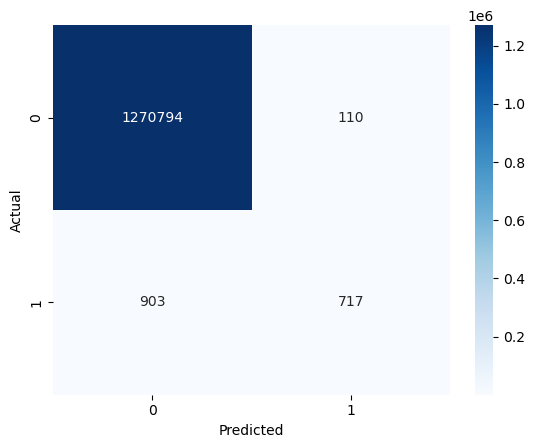

In [169]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [142]:
!pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 262.6 kB/s eta 0:03:37
   ---------------------------------------- 0.1/56.8 MB 491.5 kB/s eta 0:01:56
   ---------------------------------------- 0.6/56.8 MB 3.6 MB/s eta 0:00:16
    --------------------------------------- 0.8/56.8 MB 3.6 MB/s eta 0:00:16
    --------------------------------------- 0.8/56.8 MB 3.7 MB/s eta 0:00:15
    --------------------------------------- 0.9/56.8 MB 3.3 MB/s eta 0:00:18
    --------------------------------------- 0.9/56.8 MB 3.3 MB/s eta 0:00:18
    --------------------------------------- 1.2/56.8 MB 3.3 MB/s eta 0:00:17
   - -------------------------

In [144]:
import xgboost as xgb

In [146]:
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

In [148]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',        # good for imbalanced data
    tree_method='hist',         # fast training
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [150]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

In [151]:
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
y_pred_xgb = (y_proba_xgb > 0.5).astype(int)

In [152]:
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost ROC-AUC: 0.9994917067100988
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      1.00      0.98      1620

    accuracy                           1.00   1272524
   macro avg       0.98      1.00      0.99   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270847      57]
 [      4    1616]]


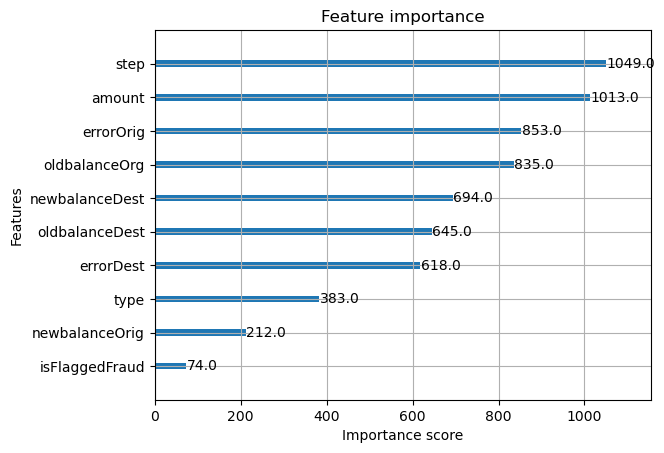

In [167]:
xgb.plot_importance(xgb_model, importance_type="weight")
plt.show()

In [ ]:
#Point 7: Prevention Strategies
#To reduce fraud while updating the company's infrastructure, I suggest combining **business rules** with **machine learning models**.

1. **Transaction Monitoring Rules**
   - Block or flag very large transactions (example: > 100,000).
   - Pay extra attention to `TRANSFER` and `CASH_OUT` types.
   - Flag suspicious cases where balance errors (`errorOrig` or `errorDest`) occur.

2. **Real-Time Alerts**
   - Send SMS/Email confirmation for high-value transactions.

3. **Two-Factor Authentication**
   - Require OTP or biometric approval for risky transfers.

4. **Daily Limits**
   - Restrict withdrawal/transfer limits for new accounts.

5. **Hybrid Approach**
   - Use ML (Logistic Regression/XGBoost) along with simple rules for maximum protection.


In [158]:
rule_pred = (
    (X_test['type'].isin(['TRANSFER','CASH_OUT'])) & 
    ( (X_test['amount'] > 100000) | (X_test['errorOrig'] != 0) )
).astype(int)

print("Rule-based strategy performance:")
print(classification_report(y_test, rule_pred, zero_division=0))
print(confusion_matrix(y_test, rule_pred))

Rule-based strategy performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.00      0.00      0.00      1620

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270904       0]
 [   1620       0]]


In [ ]:
# Point 8: Evaluating Prevention Effectiveness
#To check if prevention actions are effective, we can monitor:

1. **Before vs After Analysis**
   - Compare fraud rate before and after implementing rules/ML.

2. **A/B Testing**
   - Group A = old system, Group B = new system.
   - Measure frauds detected, false positives, and customer complaints.

3. **Key Metrics**
   - **Recall** (catching more frauds).
   - **Precision** (avoiding false alarms).
   - **Fraud Loss Reduction** in financial terms.
    
To evaluate effectiveness, we compare fraud detection recall before and after prevention measures.  
A/B testing or tracking fraud loss reduction are common approaches.

#If recall improves and fraud loss goes down without harming customers, the prevention is successful.


In [ ]:
### Conclusion
- Logistic Regression provided a simple baseline.  
- XGBoost gave better recall and ROC-AUC.  
- Rule-based prevention alone was weak, but useful in combination.  
- A hybrid system (ML + rules) with continuous monitoring is recommended.
